In [233]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt

from datetime import datetime

#### Data from https://www.arb.ca.gov/aqmis2/display.php?year=2020&param=PM25&units=001&statistic=DAVG&county_name=19-Los+Angeles&basin=--AIR+BASIN--&latitude=--PART+OF+STATE--&std15=&o3switch=new&hours=all&ptype=aqd&mon=&day=&report=AREA1YR&order=&btnsubmit=Update+Display

In [246]:
start_date = '2020-05-26'
end_date = '2020-10-18'

In [247]:
def get_values(file_path, datelist):
    df = pd.read_csv(file_path)
    
    df = df.iloc[list(range(31))]
    df.index = ["%02d" % int(x) for x in df['dom']]
    df = df.drop('dom', axis=1)
    cols = ["%02d" % x for x in range(1,13)]
    df = df.replace([" "],np.nan)
    df.columns = cols
    
    values = []
    for date in datelist:
        day = date[-2:]
        month = date[5:7]
        value = df.loc[day][month]
        values.append(value)
    return values

In [248]:
data_dir = '/Users/kevinmarlis/Developer/Thesis/Covid/Daily 2020 air data/AQMD data/'
files = os.listdir(data_dir)

data ={}

datelist = pd.date_range(start_date, end_date).tolist()
datelist = [date.to_pydatetime().strftime('%Y-%m-%d') for date in datelist]

for file in files:
    variable = file.split('_')[0]
    data[variable] = get_values(data_dir+file, datelist)

In [249]:
data_df = pd.DataFrame(data)
data_df[data_df.columns] = data_df[data_df.columns].apply(pd.to_numeric)
data_df.insert(0, 'Date', datelist)
data_df["Date"] = pd.to_datetime(data_df["Date"])
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-05-26,0.022,0.403,24.2,0.048,39.8,0.018
1,2020-05-27,0.018,0.344,19.1,0.054,38.8,0.014
2,2020-05-28,0.015,0.289,17.7,0.053,32.4,0.016
3,2020-05-29,0.010,0.236,13.4,0.044,17.7,0.007
4,2020-05-30,0.008,0.233,8.1,0.032,13.0,0.009
...,...,...,...,...,...,...,...
141,2020-10-14,0.040,1.023,22.4,0.060,47.0,0.049
142,2020-10-15,0.057,0.769,22.9,0.059,48.8,0.054
143,2020-10-16,NaN,NaN,21.4,0.050,50.9,NaN
144,2020-10-17,0.025,0.652,19.1,0.047,41.2,0.014


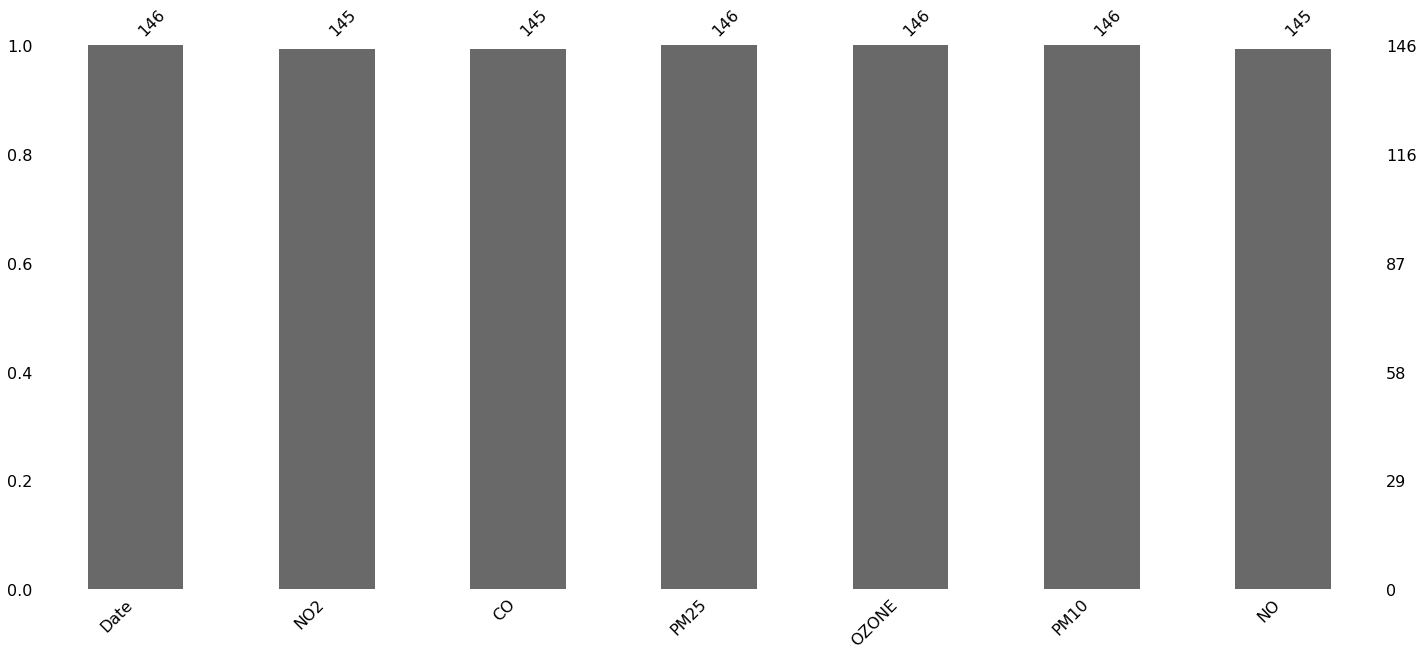

In [250]:
msno.bar(data_df)

In [251]:
# Interpolate missing data  
data_df = data_df.interpolate()
data_df

,Date,NO2,CO,PM25,OZONE,PM10,NO
0,2020-05-26,0.022,0.4030,24.2,0.048,39.8,0.018
1,2020-05-27,0.018,0.3440,19.1,0.054,38.8,0.014
2,2020-05-28,0.015,0.2890,17.7,0.053,32.4,0.016
3,2020-05-29,0.010,0.2360,13.4,0.044,17.7,0.007
4,2020-05-30,0.008,0.2330,8.1,0.032,13.0,0.009
...,...,...,...,...,...,...,...
141,2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049
142,2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054
143,2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034
144,2020-10-17,0.025,0.6520,19.1,0.047,41.2,0.014


In [252]:
#https://raw.githubusercontent.com/datadesk/california-coronavirus-data/master/latimes-county-totals.csv
target_df = pd.read_csv('/Users/kevinmarlis/Developer/Thesis/Covid/Daily 2020 air data/latimes-county-totals.csv')
target_df = target_df[target_df['county'] == 'Los Angeles']
target_df = target_df[['date', 'confirmed_cases', 'deaths', 'new_confirmed_cases', 'new_deaths']]
target_df = target_df.rename(columns={"date": "Date"})
target_df["Date"] = pd.to_datetime(target_df["Date"])
target_df = target_df.sort_values("Date", ignore_index=True)
target_df = target_df[(target_df['Date'] >= start_date) & (target_df['Date'] <= end_date)] 
target_df = target_df.interpolate(method ='linear', limit_direction ='backward', limit = 1)
target_df

,Date,confirmed_cases,deaths,new_confirmed_cases,new_deaths
121,2020-05-26,47875,2145,1852.0,29.0
122,2020-05-27,48778,2201,903.0,56.0
123,2020-05-28,49860,2241,1082.0,40.0
124,2020-05-29,51685,2294,1825.0,53.0
125,2020-05-30,53746,2339,2061.0,45.0
...,...,...,...,...,...
262,2020-10-14,285016,6812,1223.0,19.0
263,2020-10-15,286217,6834,1201.0,22.0
264,2020-10-16,287258,6856,1041.0,22.0
265,2020-10-17,288181,6863,923.0,7.0


In [253]:
df = pd.merge(left=data_df, right=target_df)
df

,Date,NO2,CO,PM25,OZONE,PM10,NO,confirmed_cases,deaths,new_confirmed_cases,new_deaths
0,2020-05-26,0.022,0.4030,24.2,0.048,39.8,0.018,47875,2145,1852.0,29.0
1,2020-05-27,0.018,0.3440,19.1,0.054,38.8,0.014,48778,2201,903.0,56.0
2,2020-05-28,0.015,0.2890,17.7,0.053,32.4,0.016,49860,2241,1082.0,40.0
3,2020-05-29,0.010,0.2360,13.4,0.044,17.7,0.007,51685,2294,1825.0,53.0
4,2020-05-30,0.008,0.2330,8.1,0.032,13.0,0.009,53746,2339,2061.0,45.0
...,...,...,...,...,...,...,...,...,...,...,...
141,2020-10-14,0.040,1.0230,22.4,0.060,47.0,0.049,285016,6812,1223.0,19.0
142,2020-10-15,0.057,0.7690,22.9,0.059,48.8,0.054,286217,6834,1201.0,22.0
143,2020-10-16,0.041,0.7105,21.4,0.050,50.9,0.034,287258,6856,1041.0,22.0
144,2020-10-17,0.025,0.6520,19.1,0.047,41.2,0.014,288181,6863,923.0,7.0


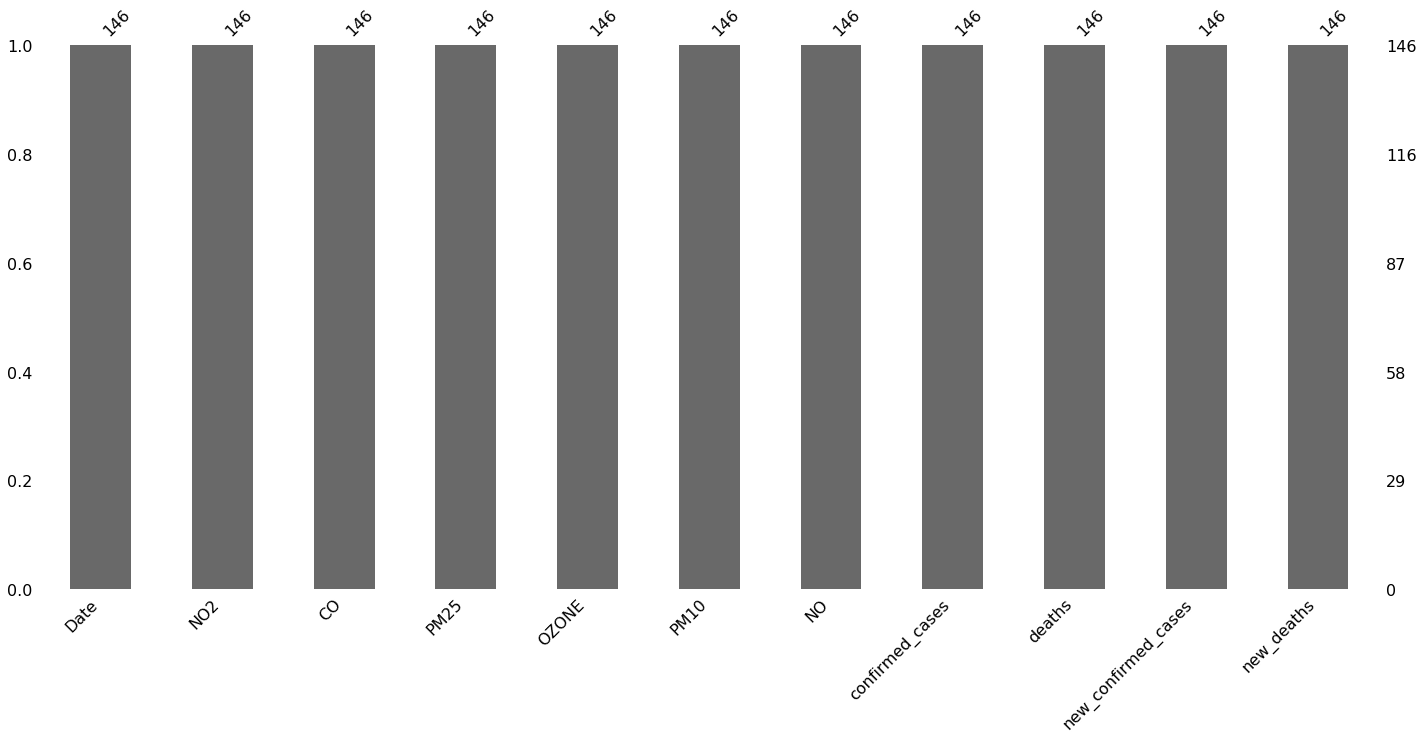

In [254]:
msno.bar(df)

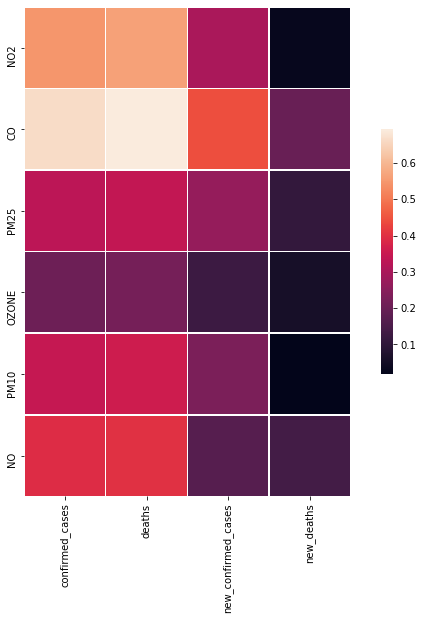

In [260]:
correlation = df.corr().abs()
correlation = correlation.drop(correlation.index[[6,7,8,9]])
correlation = correlation.drop(correlation.columns[[0,1,2,3,4,5]], axis=1)
f, ax = plt.subplots(figsize=(11, 9))
sns.heatmap(correlation,square=True, linewidths=.5, cbar_kws={"shrink": .5})